In [1]:
import matplotlib.pyplot as plt
import seaborn
import numpy as np
import os
import matplotlib as mpl
seaborn.set_context('talk')

In [2]:
with open('active_learning_data/dataset_names.txt') as f:
    names = f.readlines()
    names = [n[:-1] for n in names]
names = ['antibacterial', 'anticancer', 'antifungal', 'anti-HIV', 'anti-MRSA', 'antiparasital', 'antiviral', 'hemolytic', 'soluble', 'SHP-2', 'TULA-2', 'human']
print(names)
print(len(names))
MAX_TRAJS = 30
XLIM = 50

['antibacterial', 'anticancer', 'antifungal', 'anti-HIV', 'anti-MRSA', 'antiparasital', 'antiviral', 'hemolytic', 'soluble', 'SHP-2', 'TULA-2', 'human']
12


(0.5449203187250996, 0.046300632486142385)

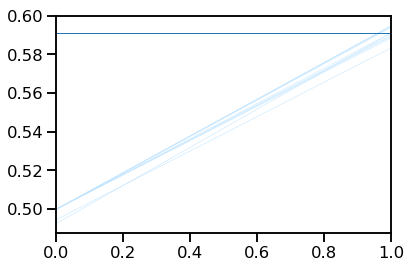

In [3]:
def plot_condition(ax, label, color, linestyle, location, trace=True, horizontal=False, xlimit=50):
    # mimic how an alpha would blend,
    # but don't use alpha so that we don't create
    # false "mean lines"
    base_color = mpl.colors.to_rgb(color)
    base_hsv = mpl.colors.rgb_to_hsv(base_color)
    base_hsv[1] *= 0.3
    base_hsv[2] = 1.0
    trace_color = mpl.colors.hsv_to_rgb(base_hsv)
    aucs, accs = [], []
    # load lines
    ax.set_xlim(0, xlimit)
    for i in range(MAX_TRAJS):
        fn = '{}/{}_withheld_accuracy.txt'.format(location, str(i).zfill(4))
        auc = '{}/{}_auc.txt'.format(location, str(i).zfill(4))
        if not os.path.exists(fn):
            break
        d = np.genfromtxt(fn)
        auc = np.genfromtxt(auc)
        aucs.append(auc)
        accs.append(d)
        if trace:
            ax.plot(d, alpha=1.0, lw=0.5, color=trace_color, linestyle=linestyle)        
    # should always go one past to get a break
    if i == 0:
        raise RuntimeError('Failed in ' + fn)
    accs = np.array(accs)
    avg = np.mean(accs, axis=0)
    if horizontal:
        ax.axhline(avg[-1], lw=1.0 if trace else 1.5, label=label, color=color, linestyle=linestyle)
    else:
        ax.plot(avg, alpha=0.9, lw=2.0 if trace else 1.5, label=label, color=color, linestyle=linestyle)
    return (np.mean(accs), np.std(accs))
plt.figure()
ax = plt.gca()
#plot_condition(ax, 'foo', 'C0', '-', 'reptile-weights/random/0/', trace=False)
plot_condition(ax, 'foo', 'C0', '-', 'models/all/8/', trace=True, horizontal=True,xlimit=1)

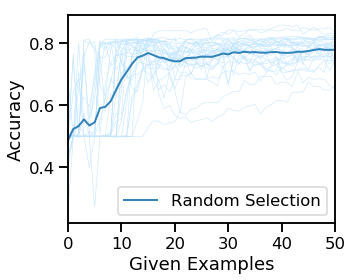

In [41]:
plt.figure(figsize=(5,4))
ax = plt.gca()
plot_condition(ax, 'Random Selection', 'C0', '-', 'models/random/0/', trace=True)
plt.legend()
plt.xlabel('Given Examples')
plt.ylabel('Accuracy')
plt.tight_layout()
plt.savefig('example.png')

In [4]:
def get_auc(location, accuracy=False, end_idx=-1):
    aucs = []
    for i in range(MAX_TRAJS):
        if accuracy:
            auc = '{}/{}_withheld_accuracy.txt'.format(location, str(i).zfill(4))
        else:
            auc = '{}/{}_auc.txt'.format(location, str(i).zfill(4))
        if not os.path.exists(auc):
            break
        auc = np.genfromtxt(auc)[end_idx] if accuracy else np.genfromtxt(auc)
        aucs.append(auc)
    # should always go one past to get a break
    if i == 0:
        raise RuntimeError('Failed in ' + auc)
    return (np.mean(aucs), np.std(aucs))
get_auc('models/qbc/1', False)

(0.8317659105229993, 0.1186081829829152)

In [5]:
def make_auc_tex_table(locations, all_loc='models', accuracy=False):
    strategy_names = ['random', 'qbc', 'umin']
    if type(locations) != list:
        locations = [locations]
    for location in locations:
        for s in strategy_names:
            print('{}-{}'.format(location,s))
    print('')
    for i,name in enumerate(names):
        auc = get_auc(os.path.join(all_loc, 'all', str(i)), accuracy=accuracy)
        print('{} & $ {:.2f}$ & '.format(name, *auc))
        for location in locations:
            for s in strategy_names:
                auc = get_auc(os.path.join(location, s, str(i)), accuracy=accuracy)
                end_char = '&' if s != strategy_names[-1] or location != locations[-1] else ''
                print('$ {1:.2f} \pm {2:.2f}$ {0} '.format( end_char, *auc))# 
        print('\\\\')

In [6]:
def make_auc_html_table(location, all_loc='models'):
    strategy_names = ['random', 'qbc', 'umin']
    for i,n in enumerate(names):
        print('<tr> <td> {} </td> '.format(n))
        auc = get_auc(os.path.join(all_loc, 'all', str(i)))
        print('<td> {:.2f} </td> '.format(auc[0]))
        for s in strategy_names:
            auc = get_auc(os.path.join(location, s, str(i)))
            print('<td> {:.2f} ± {:.2f} </td> '.format(*auc))# if s != strategy_names[-1] else '')
        print('</tr>')
make_auc_html_table('reptile-models')

<tr> <td> antibacterial </td> 
<td> 0.94 </td> 
<td> 0.87 ± 0.05 </td> 
<td> 0.88 ± 0.02 </td> 
<td> 0.85 ± 0.13 </td> 
</tr>
<tr> <td> anticancer </td> 
<td> 0.86 </td> 
<td> 0.87 ± 0.03 </td> 
<td> 0.84 ± 0.02 </td> 
<td> 0.84 ± 0.06 </td> 
</tr>
<tr> <td> antifungal </td> 
<td> 0.92 </td> 
<td> 0.84 ± 0.03 </td> 
<td> 0.86 ± 0.02 </td> 
<td> 0.87 ± 0.02 </td> 
</tr>
<tr> <td> anti-HIV </td> 
<td> 0.86 </td> 
<td> 0.78 ± 0.05 </td> 
<td> 0.91 ± 0.04 </td> 
<td> 0.87 ± 0.04 </td> 
</tr>
<tr> <td> anti-MRSA </td> 
<td> 1.00 </td> 
<td> 0.96 ± 0.03 </td> 
<td> 0.97 ± 0.01 </td> 
<td> 0.94 ± 0.05 </td> 
</tr>
<tr> <td> antiparasital </td> 
<td> 0.89 </td> 
<td> 0.93 ± 0.03 </td> 
<td> 0.92 ± 0.01 </td> 
<td> 0.96 ± 0.02 </td> 
</tr>
<tr> <td> antiviral </td> 
<td> 0.85 </td> 
<td> 0.74 ± 0.05 </td> 
<td> 0.85 ± 0.02 </td> 
<td> 0.81 ± 0.14 </td> 
</tr>
<tr> <td> hemolytic </td> 
<td> 0.99 </td> 
<td> 0.98 ± 0.01 </td> 
<td> 0.99 ± 0.02 </td> 
<td> 0.93 ± 0.14 </td> 
</tr>
<tr> <td> solub

In [9]:
make_auc_tex_table(['models-10', 'reptile-models-10'], all_loc='models')

models-10-random
models-10-qbc
models-10-umin
reptile-models-10-random
reptile-models-10-qbc
reptile-models-10-umin

antibacterial & $ 0.94$ & 
$ 0.84 \pm 0.01$ & 
$ 0.83 \pm 0.01$ & 
$ 0.74 \pm 0.21$ & 
$ 0.84 \pm 0.01$ & 
$ 0.80 \pm 0.11$ & 
$ 0.83 \pm 0.02$  
\\
anticancer & $ 0.86$ & 
$ 0.87 \pm 0.15$ & 
$ 0.88 \pm 0.01$ & 
$ 0.77 \pm 0.19$ & 
$ 0.80 \pm 0.03$ & 
$ 0.84 \pm 0.05$ & 
$ 0.90 \pm 0.02$  
\\
antifungal & $ 0.92$ & 
$ 0.81 \pm 0.12$ & 
$ 0.79 \pm 0.20$ & 
$ 0.73 \pm 0.24$ & 
$ 0.84 \pm 0.02$ & 
$ 0.82 \pm 0.02$ & 
$ 0.75 \pm 0.24$  
\\
anti-HIV & $ 0.86$ & 
$ 0.89 \pm 0.14$ & 
$ 0.76 \pm 0.22$ & 
$ 0.79 \pm 0.28$ & 
$ 0.86 \pm 0.13$ & 
$ 0.79 \pm 0.15$ & 
$ 0.85 \pm 0.13$  
\\
anti-MRSA & $ 1.00$ & 
$ 1.00 \pm 0.01$ & 
$ 0.96 \pm 0.17$ & 
$ 0.84 \pm 0.30$ & 
$ 0.92 \pm 0.01$ & 
$ 0.95 \pm 0.01$ & 
$ 0.95 \pm 0.01$  
\\
antiparasital & $ 0.89$ & 
$ 0.94 \pm 0.17$ & 
$ 0.93 \pm 0.25$ & 
$ 0.91 \pm 0.24$ & 
$ 0.90 \pm 0.02$ & 
$ 0.95 \pm 0.02$ & 
$ 0.95 \pm 0.01$  
\\
anti

In [6]:
make_auc_tex_table(['models','reptile-models'], all_loc='models')
#make_auc_html_table('models')

models-random
models-qbc
models-umin
reptile-models-random
reptile-models-qbc
reptile-models-umin

antibacterial & $ 0.94$ & 
$ 0.86 \pm 0.03$ & 
$ 0.83 \pm 0.14$ & 
$ 0.89 \pm 0.02$ & 
$ 0.87 \pm 0.05$ & 
$ 0.88 \pm 0.02$ & 
$ 0.85 \pm 0.13$  
\\
anticancer & $ 0.86$ & 
$ 0.85 \pm 0.03$ & 
$ 0.83 \pm 0.12$ & 
$ 0.79 \pm 0.13$ & 
$ 0.87 \pm 0.03$ & 
$ 0.84 \pm 0.02$ & 
$ 0.84 \pm 0.06$  
\\
antifungal & $ 0.92$ & 
$ 0.85 \pm 0.02$ & 
$ 0.84 \pm 0.02$ & 
$ 0.86 \pm 0.02$ & 
$ 0.84 \pm 0.03$ & 
$ 0.86 \pm 0.02$ & 
$ 0.87 \pm 0.02$  
\\
anti-HIV & $ 0.86$ & 
$ 0.86 \pm 0.08$ & 
$ 0.88 \pm 0.05$ & 
$ 0.85 \pm 0.16$ & 
$ 0.78 \pm 0.05$ & 
$ 0.91 \pm 0.04$ & 
$ 0.87 \pm 0.04$  
\\
anti-MRSA & $ 1.00$ & 
$ 0.95 \pm 0.02$ & 
$ 0.98 \pm 0.01$ & 
$ 0.93 \pm 0.19$ & 
$ 0.96 \pm 0.03$ & 
$ 0.97 \pm 0.01$ & 
$ 0.94 \pm 0.05$  
\\
antiparasital & $ 0.89$ & 
$ 0.95 \pm 0.05$ & 
$ 0.94 \pm 0.15$ & 
$ 0.94 \pm 0.16$ & 
$ 0.93 \pm 0.03$ & 
$ 0.92 \pm 0.01$ & 
$ 0.96 \pm 0.02$  
\\
antiviral & $ 0.85$ & 

In [7]:
make_auc_tex_table(['models','reptile-models'], all_loc='models', accuracy=True)

models-random
models-qbc
models-umin
reptile-models-random
reptile-models-qbc
reptile-models-umin

antibacterial & $ 0.88$ & 
$ 0.78 \pm 0.04$ & 
$ 0.78 \pm 0.08$ & 
$ 0.81 \pm 0.02$ & 
$ 0.80 \pm 0.04$ & 
$ 0.80 \pm 0.03$ & 
$ 0.79 \pm 0.09$  
\\
anticancer & $ 0.82$ & 
$ 0.79 \pm 0.04$ & 
$ 0.78 \pm 0.07$ & 
$ 0.76 \pm 0.08$ & 
$ 0.80 \pm 0.05$ & 
$ 0.82 \pm 0.02$ & 
$ 0.78 \pm 0.06$  
\\
antifungal & $ 0.87$ & 
$ 0.77 \pm 0.05$ & 
$ 0.78 \pm 0.04$ & 
$ 0.81 \pm 0.02$ & 
$ 0.76 \pm 0.04$ & 
$ 0.80 \pm 0.03$ & 
$ 0.82 \pm 0.03$  
\\
anti-HIV & $ 0.84$ & 
$ 0.80 \pm 0.08$ & 
$ 0.79 \pm 0.05$ & 
$ 0.79 \pm 0.09$ & 
$ 0.71 \pm 0.05$ & 
$ 0.85 \pm 0.05$ & 
$ 0.82 \pm 0.04$  
\\
anti-MRSA & $ 0.96$ & 
$ 0.90 \pm 0.03$ & 
$ 0.95 \pm 0.02$ & 
$ 0.94 \pm 0.12$ & 
$ 0.95 \pm 0.04$ & 
$ 0.95 \pm 0.02$ & 
$ 0.93 \pm 0.01$  
\\
antiparasital & $ 0.89$ & 
$ 0.89 \pm 0.07$ & 
$ 0.91 \pm 0.08$ & 
$ 0.91 \pm 0.11$ & 
$ 0.90 \pm 0.03$ & 
$ 0.90 \pm 0.03$ & 
$ 0.94 \pm 0.03$  
\\
antiviral & $ 0.76$ & 

In [11]:
make_auc_tex_table(['models-10','reptile-models-10'], all_loc='models', accuracy=True)

models-10-random
models-10-qbc
models-10-umin
reptile-models-10-random
reptile-models-10-qbc
reptile-models-10-umin

antibacterial & $ 0.88$ & 
$ 0.74 \pm 0.10$ & 
$ 0.75 \pm 0.06$ & 
$ 0.66 \pm 0.13$ & 
$ 0.79 \pm 0.03$ & 
$ 0.73 \pm 0.10$ & 
$ 0.79 \pm 0.06$  
\\
anticancer & $ 0.82$ & 
$ 0.77 \pm 0.13$ & 
$ 0.79 \pm 0.10$ & 
$ 0.71 \pm 0.11$ & 
$ 0.76 \pm 0.08$ & 
$ 0.81 \pm 0.07$ & 
$ 0.86 \pm 0.02$  
\\
antifungal & $ 0.87$ & 
$ 0.71 \pm 0.12$ & 
$ 0.71 \pm 0.14$ & 
$ 0.67 \pm 0.14$ & 
$ 0.79 \pm 0.06$ & 
$ 0.78 \pm 0.06$ & 
$ 0.74 \pm 0.14$  
\\
anti-HIV & $ 0.84$ & 
$ 0.71 \pm 0.19$ & 
$ 0.73 \pm 0.15$ & 
$ 0.75 \pm 0.15$ & 
$ 0.79 \pm 0.11$ & 
$ 0.77 \pm 0.10$ & 
$ 0.79 \pm 0.13$  
\\
anti-MRSA & $ 0.96$ & 
$ 0.93 \pm 0.13$ & 
$ 0.92 \pm 0.12$ & 
$ 0.82 \pm 0.15$ & 
$ 0.87 \pm 0.07$ & 
$ 0.95 \pm 0.01$ & 
$ 0.93 \pm 0.02$  
\\
antiparasital & $ 0.89$ & 
$ 0.86 \pm 0.15$ & 
$ 0.81 \pm 0.16$ & 
$ 0.83 \pm 0.15$ & 
$ 0.85 \pm 0.11$ & 
$ 0.92 \pm 0.08$ & 
$ 0.92 \pm 0.02$  
\\
anti

In [4]:
def plot_dataset(ax, ml_location, location, strategy, index, xlabel=False, ylabel=False, legend=False, ml=True, zoom=False, title=None, baseline_loc=None, xlimit=50):
    if title is None:
        ax.set_title(names[index])
    else:
        ax.set_title(title)
    if baseline_loc is None:
        baseline_loc = location
    index = str(index)
    strategy_names = {'umin': 'Uncertainty', 'qbc': 'QBC'}
    accs = []
    accs.append(plot_condition(ax, 'Baseline', 'gray', '-', os.path.join(baseline_loc, 'all', index), trace=False, horizontal=True, xlimit=xlimit))
    if strategy is not None:
        accs.append(plot_condition(ax, strategy_names[strategy], 'C0', '-', os.path.join(location, strategy, index), trace=not ml, xlimit=xlimit))
        accs.append(plot_condition(ax, 'Random', 'C2', '--', os.path.join(location, 'random', index), trace=False, xlimit=xlimit))
    else:
        accs.append(plot_condition(ax, 'Random', 'C0', '-', os.path.join(location, 'random', index), trace=True, xlimit=xlimit))
        
    if ml:
        accs.append(plot_condition(ax, 'ML+' + strategy_names[strategy], 'C1', '-', os.path.join(ml_location, strategy, index), trace=True, xlimit=xlimit))
        accs.append(plot_condition(ax, 'ML+Random', 'C3', '--', os.path.join(ml_location, 'random', index), trace=False, xlimit=xlimit))
    if zoom:
        ax.set_xlim(0,5)
        #ax.set_ylim(0.45,0.75)
    else:
        ax.set_xlim(0,xlimit)
        #ax.set_ylim(0.45,1.0)
    ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    ax.set_xticks([0,xlimit // 2, xlimit])
    
    if legend:
        ax.legend()
    if xlabel:
        ax.set_xlabel('Given Examples')
    if ylabel:
        ax.set_ylabel('Accuracy')
    return accs

In [5]:
def plot_strategy(ml_location, location, strategy, ml=True, zoom=False, stop=len(names), xlimit=50, baseline_loc=None):
    fig, axs= plt.subplots(nrows=3, ncols=4, figsize=(14,8), sharex=True, sharey=False)
    print('Data Standard'.format(strategy))
    if ml:
        print(' ML+{} ML+Random'.format(strategy))
    else:
        print(' {} Random'.format(strategy))
    for i in range(3):
        for j in range(4):
            k = i * 4 + j
            line = [names[k]] + plot_dataset(axs[i,j], ml_location, location, strategy, k, 
                                             xlabel = i == 2, ylabel=j == 0,
                                             legend = k == len(names), ml=ml, zoom=zoom,
                                             xlimit=xlimit, baseline_loc=baseline_loc)
            if k == 7:
                axs[i,j].legend(loc='upper right', bbox_to_anchor=(2.0, 1.0), fancybox=True, shadow=True, fontsize=10)
    plt.tight_layout()
    plt.savefig('{}{}{}.png'.format(strategy, '-ml' if ml else '', '-zoom' if zoom else ''), dpi=300)

Data Standard
 ML+umin ML+Random


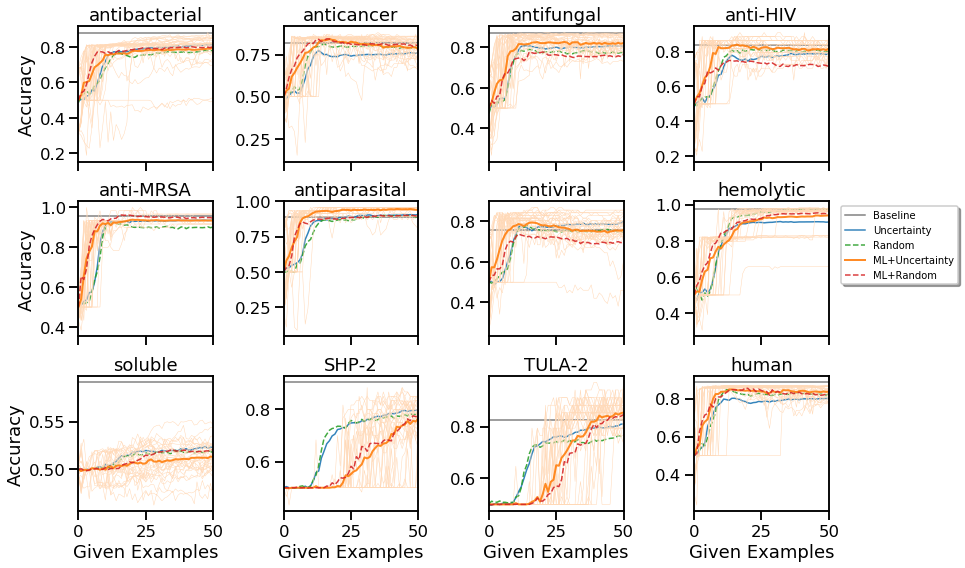

In [6]:
plot_strategy('reptile-models', 'models', 'umin', ml=True)

Data Standard
 ML+qbc ML+Random


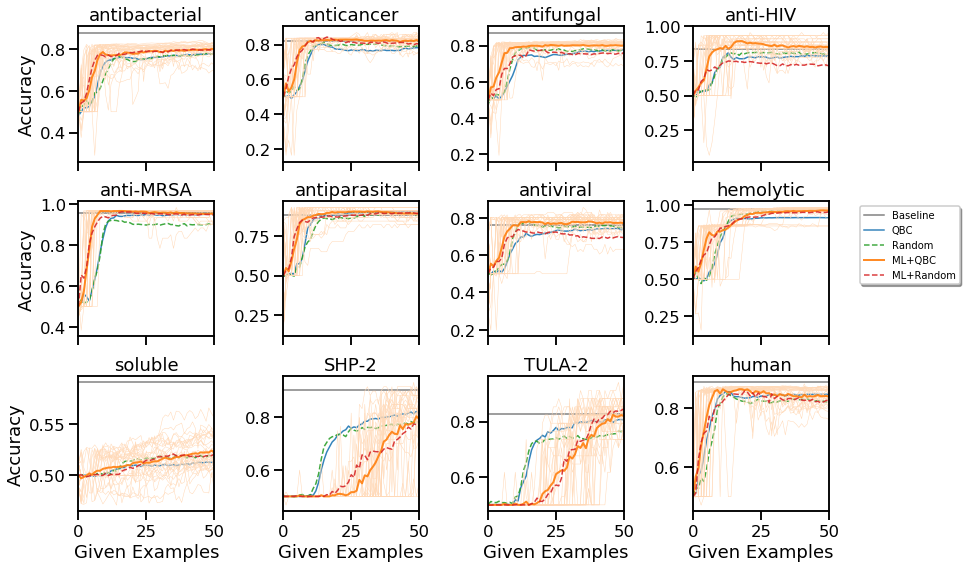

In [7]:
plot_strategy('reptile-models', 'models', 'qbc', ml=True)

Data Standard
 None Random


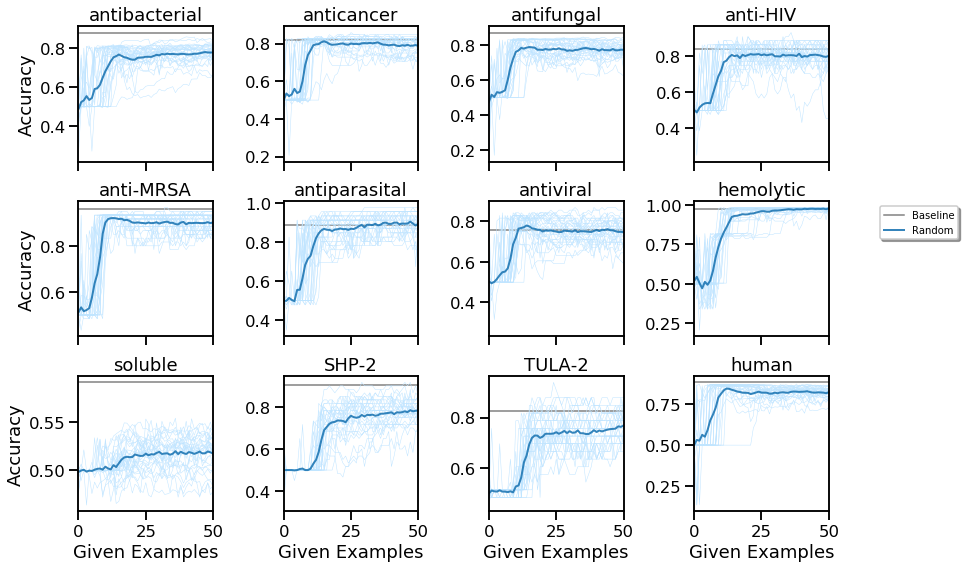

In [44]:
plot_strategy('reptile-models', 'models', None, ml=False)

Data Standard
 umin Random


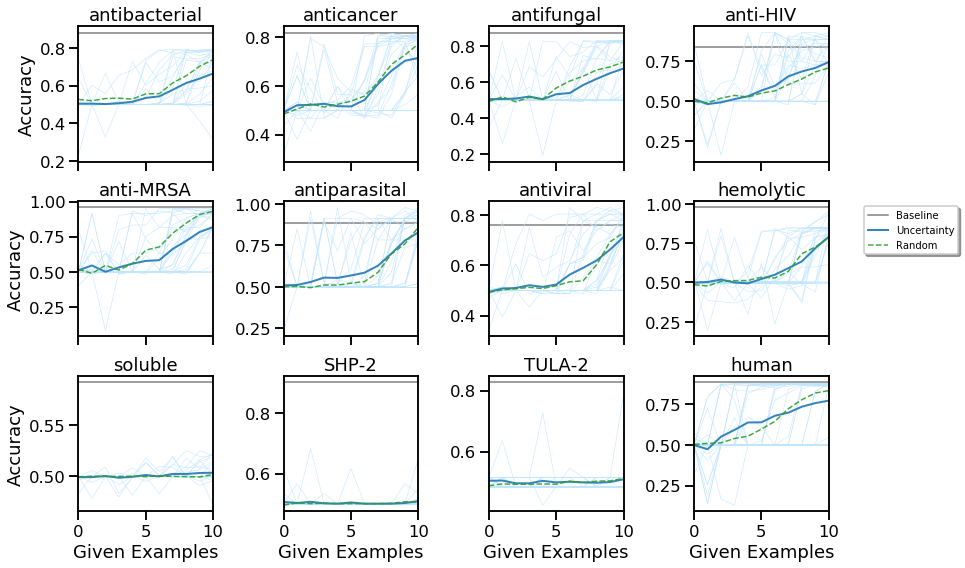

In [67]:
plot_strategy('reptile-models-10', 'models-10', 'umin', ml=False, xlimit=10, baseline_loc='models')

Data Standard
 qbc Random


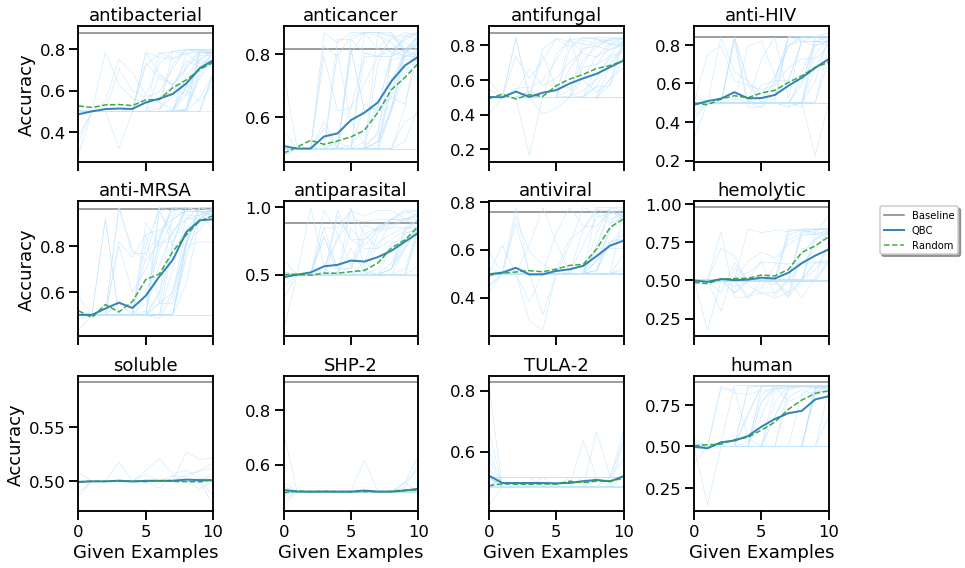

In [68]:
plot_strategy('reptile-models-10', 'models-10', 'qbc',baseline_loc='models',xlimit=10, ml=False)

Data Standard
 ML+umin ML+Random


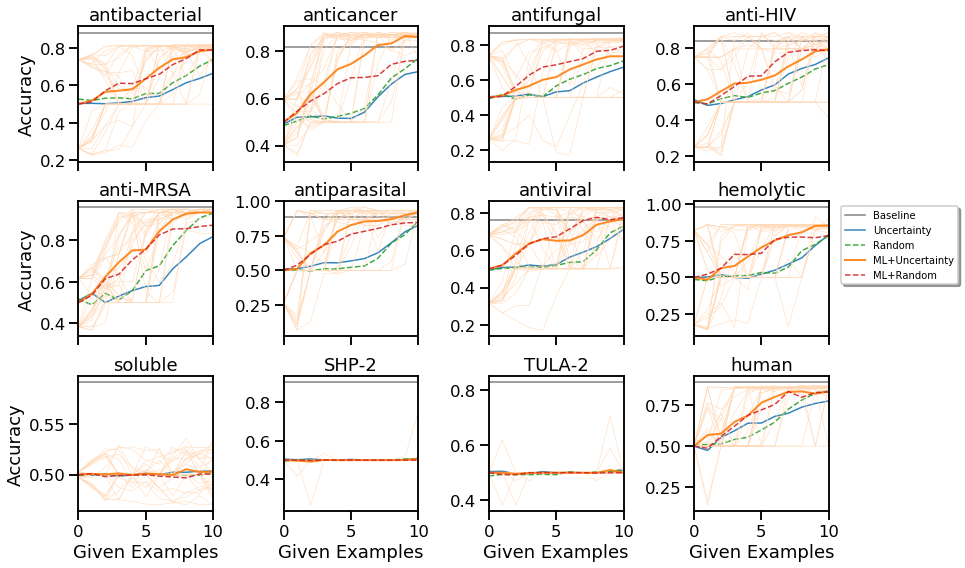

In [64]:
plot_strategy('reptile-models-10', 'models-10', 'umin', ml=True, xlimit=10, baseline_loc='models')

Data Standard
 ML+qbc ML+Random


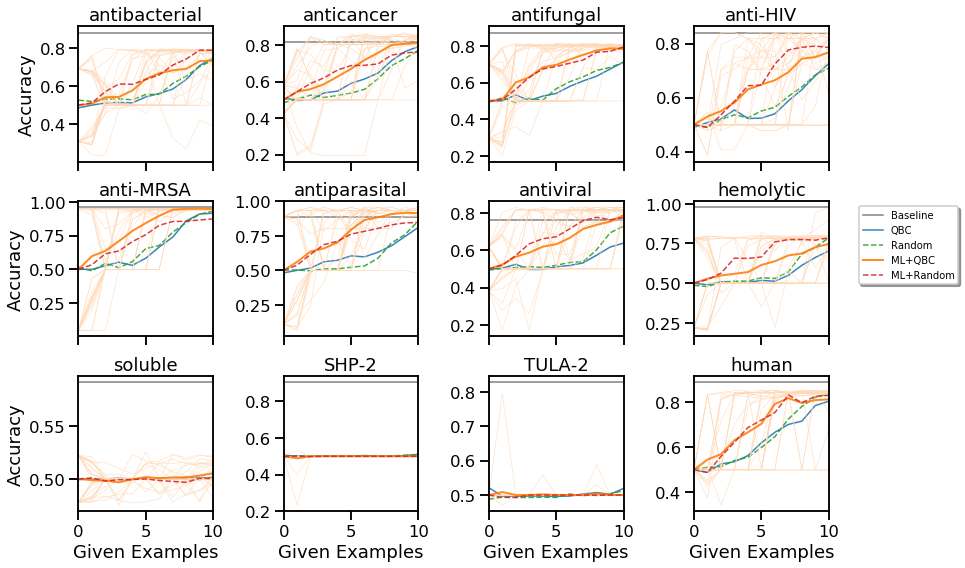

In [65]:
plot_strategy('reptile-models-10', 'models-10', 'qbc', ml=True, xlimit=10, baseline_loc='models')

In [39]:
ALPHABET = ['A','R','N','D','C','Q','E','G','H','I', 'L','K','M','F','P','S','T','W','Y','V']

def decode_motif(array):
    return ''.join([ALPHABET[int(i)] for i in array])

def mode(motifs):
    '''
    computes mode
    '''
    motifs.sort()
    last = motifs[0]
    mode,mode_count,count = last,1,1
    for m in motifs[1:]:
        if m == last:
            count += 1
        elif count >= mode_count:
            mode = last
            mode_count = count
            count = 1
        else:
            count = 1
        last = m
    if count >= mode_count:
        mode = last
        mode_count = count
    return (mode, 1.*mode_count / (1.*len(motifs)))
print(mode(['GGG', 'GGG', 'ERG', 'DFH']))
print(mode(['GGG', 'GGG', 'ERG', 'DFH', 'DFH']))
print(mode(['GGG', 'GGG', 'ERG', 'DFH', 'DFH', 'DFH']))
print(decode_motif([1., 11., 0., 19.]))

('GGG', 0.5)
('GGG', 0.4)
('DFH', 0.5)
RKAV


In [40]:
def get_motifs(location):
    motifs = []
    for i in range(MAX_TRAJS):
        motif_path = '{}/{}_motifs.txt'.format(location, str(i).zfill(4))
        if not os.path.exists(motif_path):
            break
        m = np.genfromtxt(motif_path)
        # sort them so we can get around lack of ordering. 
        motifs.append([decode_motif(mi) for mi in m])
        motifs[-1].sort()
    # should always go one past to get a break
    if i == 0:
        raise RuntimeError('Failed in ' + motif_path)
    # now we need to histogram them
    motif_modes = []
    for i in range(len(motifs[0])):
        motif_modes.append(mode([m[i] for m in motifs]))
    # sort them
    motif_modes.sort(key = lambda x: x[1])
    return motif_modes
get_motifs('models/all/0')

[('EIDQLV', 0.1),
 ('ELLCKF', 0.1),
 ('EMWWCE', 0.1),
 ('GVVQCV', 0.1),
 ('KWEEIE', 0.1),
 ('WLMEME', 0.1)]

In [41]:
def get_count_grads(location):
    count_grads = []
    for i in range(MAX_TRAJS):
        path = '{}/{}_count_grads.txt'.format(location, str(i).zfill(4))
        if not os.path.exists(path):
            break
        m = np.genfromtxt(path)
        count_grads.append(m)
    # should always go one past to get a break
    if i == 0:
        raise RuntimeError('Failed in ' + path)
    # now we need to get mean
    cg_mean = np.mean(count_grads, axis=0)
    #print('TODO: I do not know if this is valid....')
    #cg_mean -= np.mean(cg_mean)
    cg_mean = np.abs(cg_mean)
    return cg_mean
get_count_grads('models/all/0')

array([0.24031213, 1.15102466, 0.5460943 , 3.27338407, 7.59650163,
       0.32326711, 2.09414151, 8.01711158, 1.07356015, 0.41428204,
       2.59127012, 2.78997715, 2.17427872, 1.48956725, 2.09663104,
       0.88844434, 0.57228252, 3.0532126 , 3.79512813, 3.80780249,
       2.55191153])

In [42]:
def plot_explain(location, name, motif_width=6, ax=None, labelx = True, labely_left = True, labely_right = True):
    if ax is None:
        plt.figure()
        ax = plt.gca()
    ax.grid(linewidth=1, linestyle='--', zorder=1)
    
    cg = get_count_grads(location)
    print(cg)
    # make y-axis symmetric
    ymax = max(abs(min(cg)), abs(max(cg)))
    ax.set_ylim(0, ymax)
    x = list(range(len(cg)))
    ax.bar(x, height=cg, zorder=99)
    ax.set_yticks([])
    if labelx:
        #ax.set_xticks(x + [x[-1] + 1 + motif_width // 2])
        ax.set_xticks(x)
        ax.set_xticklabels(['Z'] + ALPHABET + ['Motifs'], fontdict={'size': 18, 'family': 'monospace'})
    else:
        ax.set_xticks(x)
        ax.set_xticklabels(['Z'] + ALPHABET, fontdict={'size': 12, 'family': 'monospace'})
    if labely_left:
        ax.set_ylabel('Class Effect', fontsize=24)
    ax.set_xlim(-1,x[-1] + 1 + motif_width)
    ax.axvline(x[-1] + 1, color='black')
    ax2 = ax.twinx()
    motifs = get_motifs(location)
    yticks = []
    for i,m in enumerate(motifs):
        y = i + 0.5
        yticks.append(y)
        ax2.text(x[-1] + 0.5 + motif_width, y, verticalalignment='center', 
                s=motifs[i][0], fontdict={'size': 16, 'family': 'monospace'},
               horizontalalignment='right')
    ax2.set_ylim(0,len(motifs))
    ax2.set_yticks(yticks)
    ax2.set_yticklabels(['{:.2f}'.format(m[1]) for m in motifs])
    if labely_right:
        ax2.yaxis.set_label_position('right')
        ax2.set_ylabel('Motif Frequency', rotation=-90, labelpad=25, fontsize=24)
    ax.set_title(name, fontsize=24)

[8.07218511e-05 1.97115095e-02 6.03838812e-03 1.38310495e-02
 4.02862967e-02 2.65140531e-02 4.25191544e-02 3.92734522e-02
 8.62084236e-03 2.41906450e-02 1.42995071e-02 5.50142602e-02
 1.95075574e-02 3.02180789e-02 7.31605766e-02 3.61648590e-03
 9.00721650e-03 3.67088945e-04 5.71546147e-02 4.25738894e-02
 3.70270119e-03]
[0.20100759 0.01076443 0.09340339 0.08767457 0.0180863  0.02386489
 0.01128299 0.05774897 0.13650957 0.09670939 0.04454522 0.09273493
 0.07258912 0.08586607 0.04847402 0.20696328 0.03489862 0.11084238
 0.1103628  0.18262162 0.03452957]


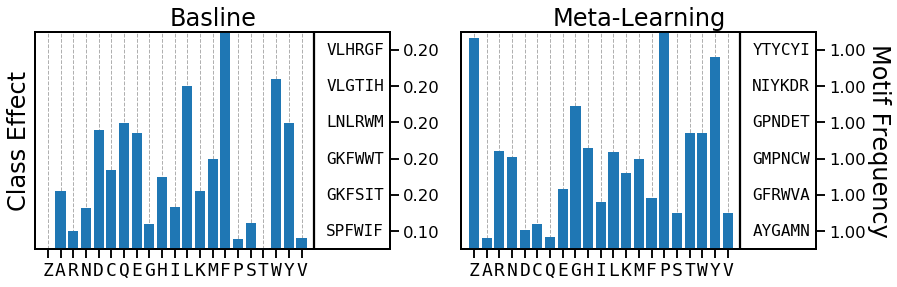

In [36]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(14, 4))
plot_explain('models/all/7', 'Basline', ax=axs[0], labely_left=True, labelx=True, labely_right=False)
plot_explain('reptile-models/umin/7zero', 'Meta-Learning', ax=axs[1], labely_right=True, labely_left=False, labelx=True)
plt.savefig('interp-compare.png', dpi=300)
plt.show()

In [43]:
def plot_interpret(location_root, strategy, suffix=''):
    fig, axs= plt.subplots(nrows=3, ncols=4, figsize=(28,16), sharex=False, sharey=False)
    for i in range(3):
        for j in range(4):
            k = i * 4 + j
            plot_explain(os.path.join(location_root, strategy, '{}{}'.format(k, suffix)), 
                         names[k], ax=axs[i,j], labelx = i == 2, labely_right = j == 3,
                         labely_left = j == 0)
    plt.savefig('interpret-{}.png'.format(strategy), dpi=300)
    #plt.show()

[0.43565126 0.10525154 0.19297034 0.0873473  0.05624382 0.05956868
 0.04320947 0.11180047 0.07952824 0.12658284 0.14013362 0.05225156
 0.03702435 0.05542831 0.07515417 0.09243465 0.07329761 0.27345826
 0.00504632 0.10321545 0.0598197 ]
[0.59686747 0.14238907 0.13602725 0.05845788 0.16260519 0.03701167
 0.28944589 0.33092258 0.21000562 0.04581399 0.09288085 0.10412032
 0.11774078 0.14652153 0.19602957 0.00795099 0.10634791 0.26440438
 0.03915877 0.0813829  0.19320466]
[4.48231263e-01 8.40067961e-02 2.10341392e-01 1.32908532e-01
 2.03863957e-04 1.28099691e-02 1.00227057e-01 2.62614031e-01
 7.21397442e-02 1.57635615e-01 7.08786357e-02 2.42584576e-01
 1.86755466e-01 3.48910266e-02 1.50609724e-01 1.21912828e-01
 1.18041851e-01 3.34276466e-02 3.41019155e-02 1.48971430e-02
 2.33722378e-01]
[0.1168286  0.04162526 0.08323538 0.08391837 0.05986969 0.05922913
 0.09145628 0.04712715 0.12392829 0.02028248 0.06552724 0.04362275
 0.10979797 0.04846534 0.0244714  0.02828664 0.05755861 0.06124029
 0.08

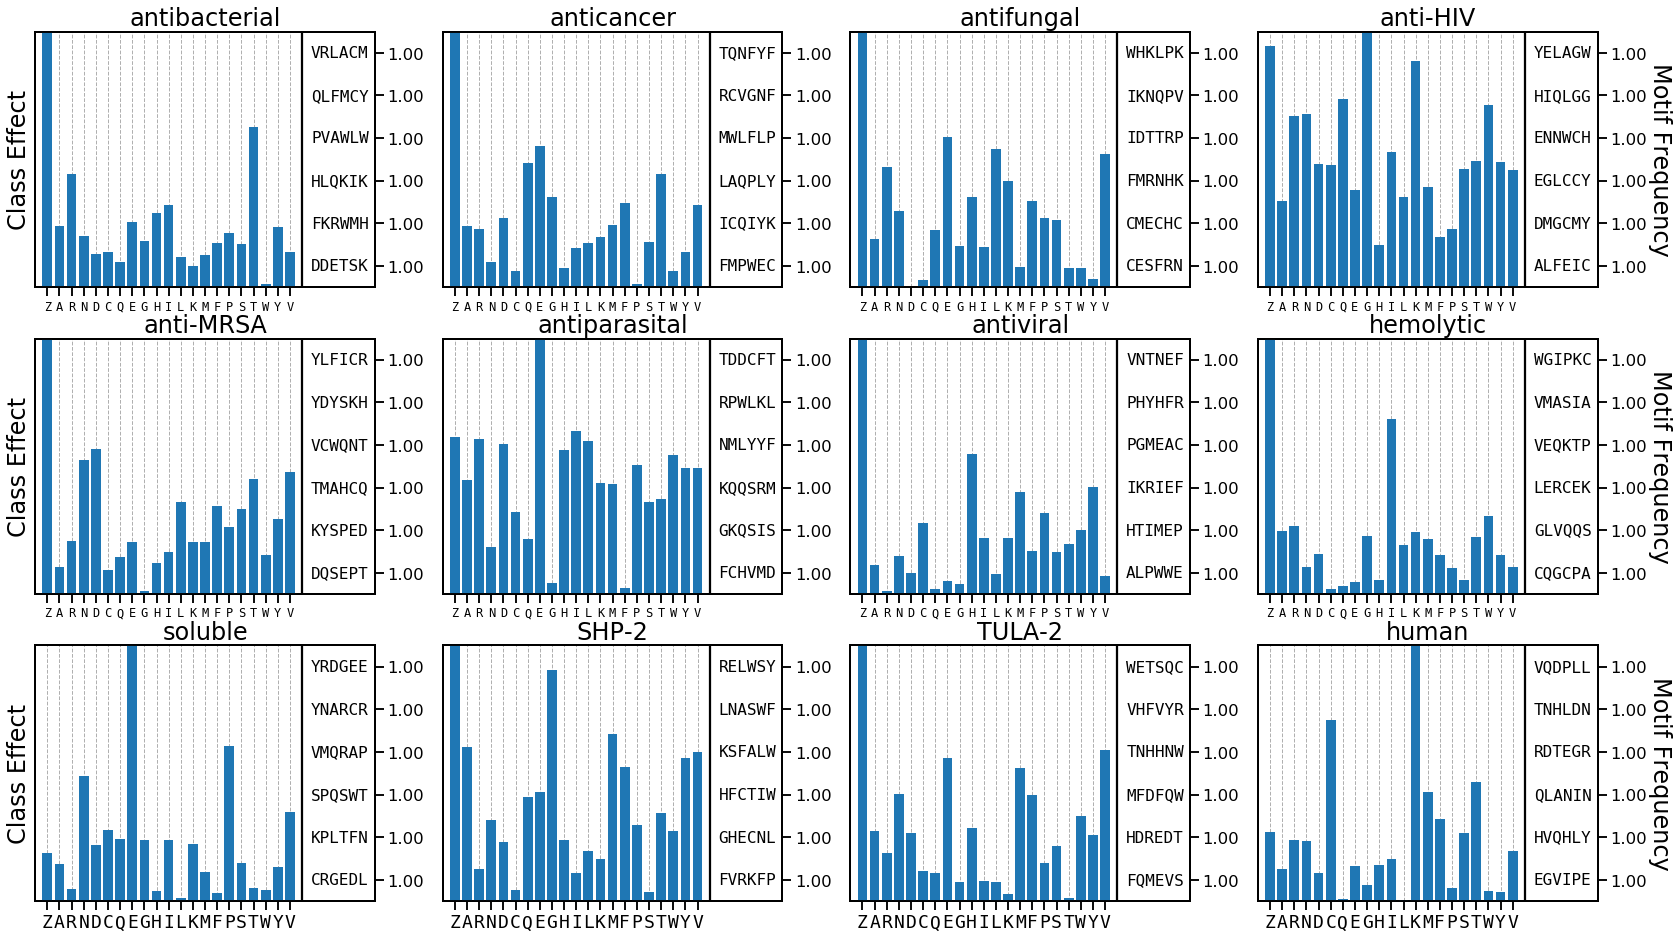

In [44]:
plot_interpret('reptile-models/', 'random', 'zero')

[0.24031213 1.15102466 0.5460943  3.27338407 7.59650163 0.32326711
 2.09414151 8.01711158 1.07356015 0.41428204 2.59127012 2.78997715
 2.17427872 1.48956725 2.09663104 0.88844434 0.57228252 3.0532126
 3.79512813 3.80780249 2.55191153]
[0.04616984 0.06423241 0.11490372 0.07654031 0.03582453 0.09330065
 0.05516844 0.11899817 0.16254383 0.08591172 0.15489998 0.10398664
 0.01507793 0.0907464  0.13147631 0.28235883 0.18442967 0.06794373
 0.11875741 0.1481696  0.030216  ]
[0.27235111 0.51141633 0.07979649 1.19682012 3.32148834 0.91845025
 0.4703583  3.61930876 0.09353901 2.31229546 0.67396523 2.39098955
 3.00561757 0.88924791 2.53551213 1.12829018 0.74876274 1.56873527
 1.85379976 1.92557653 2.38966228]
[0.14471805 0.02503155 0.26166201 0.02827609 0.18442797 0.11034598
 0.03566379 0.22016696 0.13927398 0.07171469 0.10655931 0.18555833
 0.05619347 0.09006944 0.06103718 0.11928684 0.06907608 0.18284153
 0.06188501 0.00302015 0.01579485]
[0.14207365 0.09960471 0.1349123  0.09390796 0.15007765 0

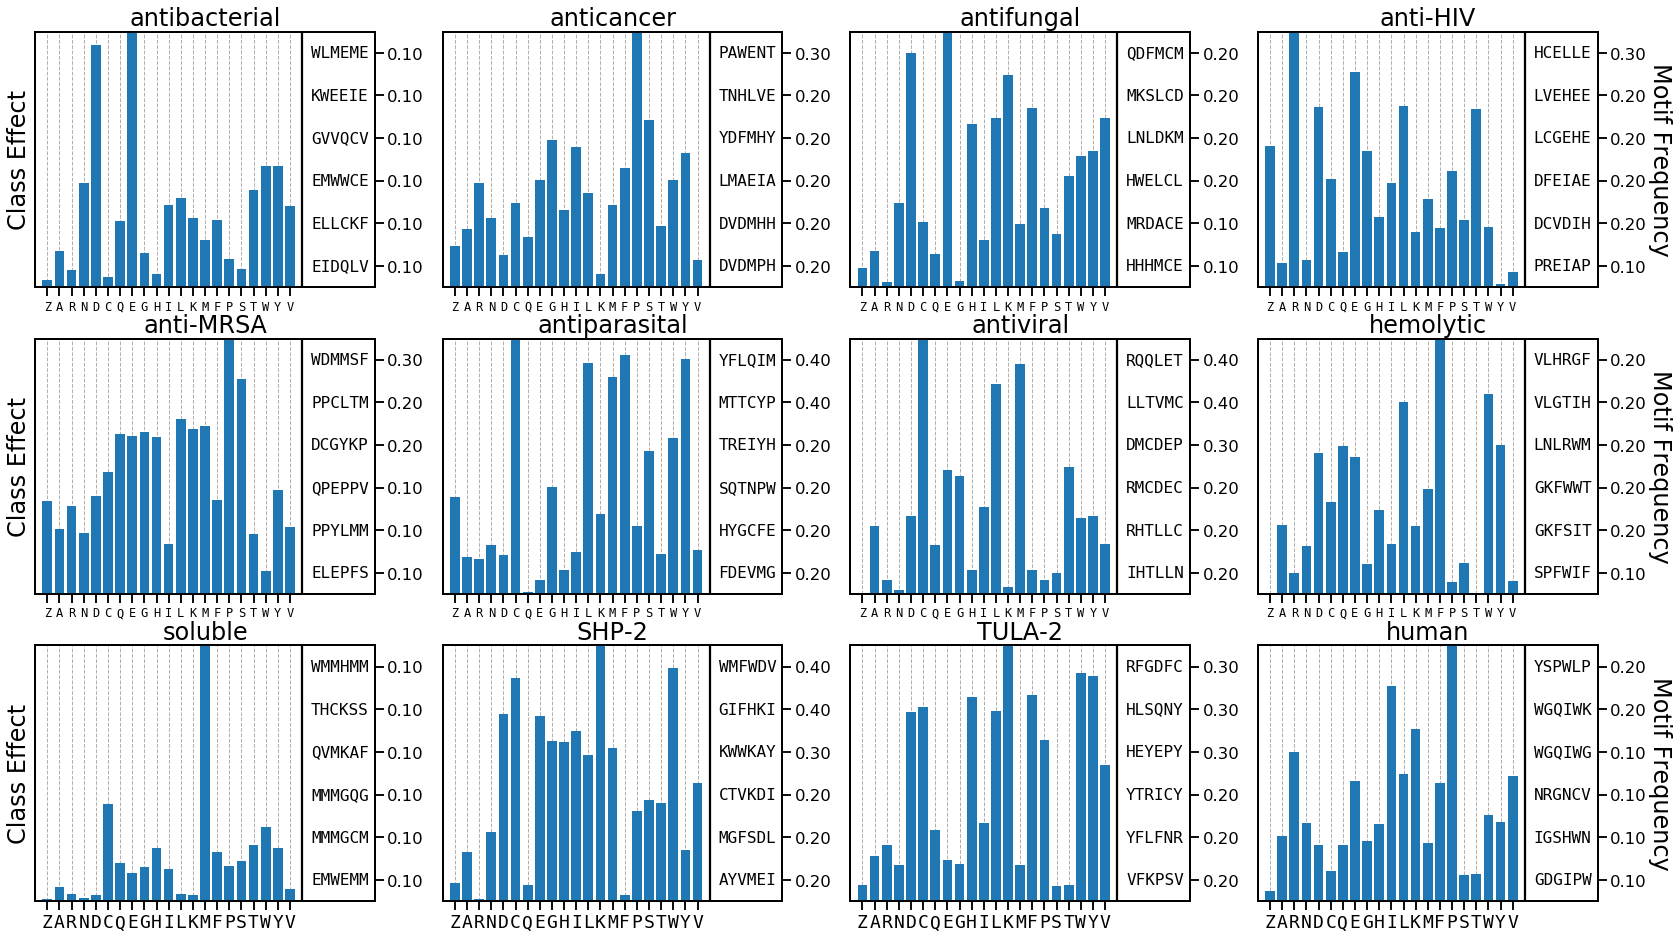

In [45]:
plot_interpret('models', 'all')

<Figure size 180x144 with 0 Axes>

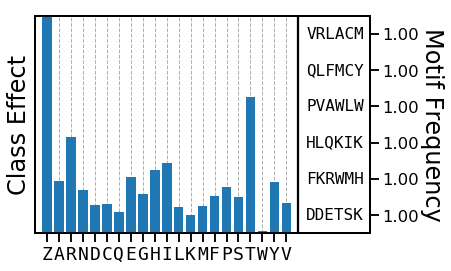

In [31]:
plt.figure(figsize=(2.5,2))
plot_explain(os.path.join('reptile-models', 'random', '{}{}'.format(0, 'zero')), 
                         '', labelx = True, labely_right=True,
                         labely_left = True)
plt.show()

RuntimeError: Failed in test-reptile-models/random/0/0000_withheld_accuracy.txt

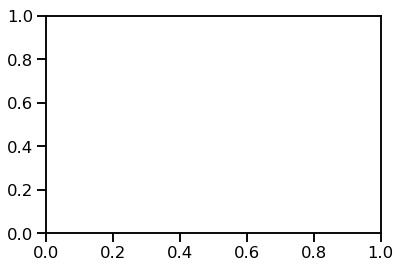

In [34]:
plt.figure()
ax = plt.gca()
plot_condition(ax, 'foo', 'C0', '-', 'test-reptile-models/random/0', trace=True)
plot_condition(ax, 'foo', 'C1', '-', 'test-reptile-models/umin/0/', trace=True)
plt.show()

(25, 51)
(25, 51)
(30, 51)


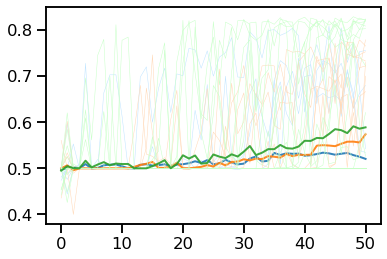

In [565]:
plt.figure()
ax = plt.gca()
plot_condition(ax, 'foo', 'C0', '-', 'models-/random/0', trace=True)
plot_condition(ax, 'foo', 'C1', '-', 'test-models/umin/0/', trace=True)
plot_condition(ax, 'foo', 'C2', '-', 'models/qbc/0/', trace=True)
#plt.xlim(0,25)
plt.show()

(30, 51)


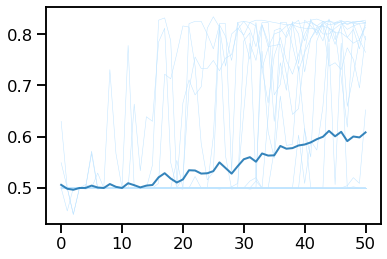

In [564]:
plt.figure()
ax = plt.gca()
plot_condition(ax, 'foo', 'C0', '-', 'models/qbc/2', trace=True)
plt.show()

[(0.935032174556213, 0.0013019178159449597),
 (0.887001633382643, 0.020537176085224873),
 (0.8473127465483236, 0.03434142689924096),
 (0.8767423816568047, 0.0227380933518444),
 (0.8450056089743588, 0.04296314793153071)]

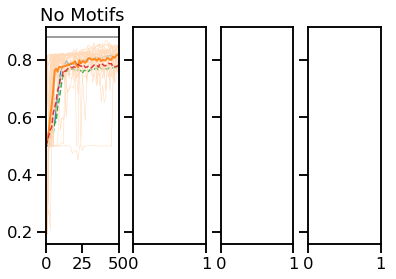

In [9]:
fix, axs = plt.subplots(nrows=1, ncols=4, sharey=True)
plot_dataset(axs[0], 'ablation-reptile-no-motifs', 'ablation-no-motifs','qbc', 0, False, ml=True, title='No Motifs', baseline_loc='models')

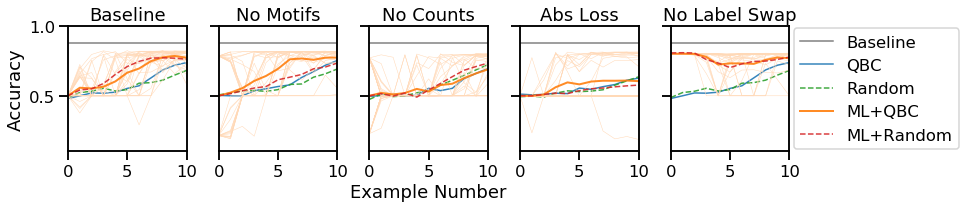

In [9]:
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(14, 3), sharey=True)
plot_dataset(axs[0], 'reptile-models', 'models', 'qbc', 0, False, ml=True, title='Baseline', xlimit=10)
plot_dataset(axs[1], 'ablation-reptile-no-motifs', 'ablation-no-motifs', 'qbc', 0, False, ml=True, title='No Motifs', baseline_loc='models', xlimit=10)
plot_dataset(axs[2], 'ablation-reptile-no-counts', 'ablation-no-counts', 'qbc', 0, False, ml=True, title='No Counts', baseline_loc='models', xlimit=10)
#axs[1].yaxis.set_labels([])
plot_dataset(axs[3], 'ablation-reptile-abs-loss', 'ablation-abs-loss', 'qbc', 0, False, ml=True, title='Abs Loss', baseline_loc='models', xlimit=10)
#axs[2].yaxis.set_tricks([])
plot_dataset(axs[4], 'ablation-reptile-no-labels', 'models', 'qbc', 0, False, ml=True, title='No Label Swap', baseline_loc='models', xlimit=10)

axs[0].set_ylabel('Accuracy')
axs[2].set_xlabel('Example Number')
for ax in axs:
    #ax.set_xlim(0,10)
    #ax.set_xticks([0,5,10])
    ax.set_ylim(0.1,1.0)
plt.legend(loc='center right', bbox_to_anchor=(2.5, 0.5))
plt.tight_layout()
plt.savefig('ablation.png', dpi=300)
plt.show()


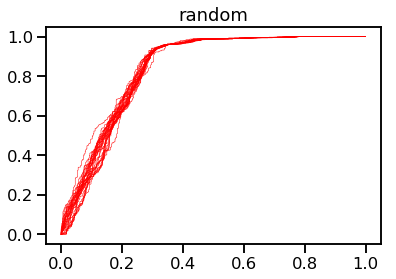

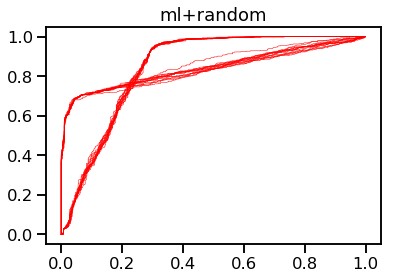

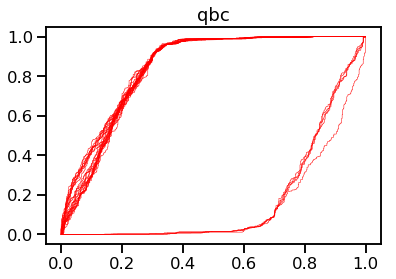

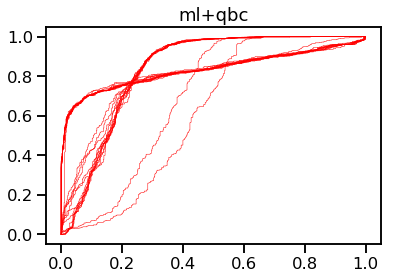

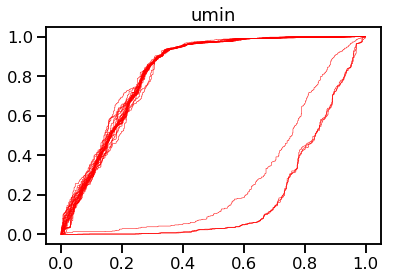

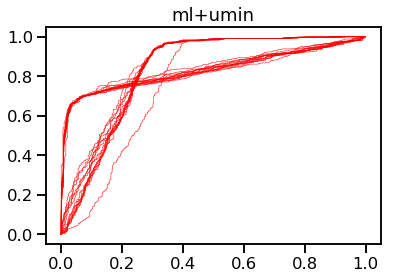

In [10]:
def plot_roc(ax, location, trace=True, color='red'):
    fprs, tprs = [], []
    # load lines
    for i in range(MAX_TRAJS):
        fpr_path = '{}/{}_fpr.npy'.format(location, str(i).zfill(4))
        tpr_path = '{}/{}_tpr.npy'.format(location, str(i).zfill(4))
        if not os.path.exists(fpr_path):
            break
        fpr = np.load(fpr_path)
        fprs.append(fpr)
        tpr = np.load(tpr_path)
        tprs.append(tpr)
        if trace:
            ax.plot(fpr, tpr, alpha=1.0, lw=0.5, color=color)        
    # should always go one past to get a break
    if i == 0:
        raise RuntimeError('Failed in ' + fpr_path)
    fprs = np.array(fprs)
    tprs = np.array(tprs)
    #return (np.mean(aucs), np.std(aucs))

for method in ['random','qbc','umin']:
    plt.figure()
    ax = plt.gca()
    plt.title(method)
    plot_roc(ax, 'models-10/{}/0'.format(method))
    plt.figure()
    ax = plt.gca()
    plt.title('ml+'+method)
    plot_roc(ax, 'reptile-models-10/{}/0'.format(method))
    
